In [31]:
import os,sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from multiprocessing import Pool
from functools import partial

import h5py as h5

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly as plotly
import plotly.io as pio


from multiprocessing import Pool
from functools import partial
import json

import urllib.request
pd.options.mode.chained_assignment = None 


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)





class IgraMetaData():
    """ Class holfing the basic functionality to produce extract IGRA2 metadata information """
    
    def __init__(self):

        """ Convert the IGRA2 metadata from plain txt into a dataframe,
        for the select station WMO id """

        """
        IGRAID         1- 11   Character
        WMOID         13- 17   Integer
        NAME          19- 48   Character
        NAMFLAG       50- 50   Character
        LATITUDE      52- 60   Real
        LATFLAG       62- 62   Character
        LONGITUDE     64- 72   Real
        LONFLAG       74- 74   Character
        ELEVATION     76- 81   Real
        ELVFLAG       83- 83   Character
        YEAR          85- 88   Integer
        MONTH         90- 91   Integer
        DAY           93- 94   Integer
        HOUR          96- 97   Integer
        DATEIND       99- 99   Integer
        EVENT        101-119   Character
        ALTIND       121-122   Character
        BEFINFO      124-163   Character
        BEFFLAG      164-164   Character
        LINK         166-167   Character
        AFTINFO      169-208   Character
        AFTFLAG      209-209   Character
        REFERENCE    211-235   Character
        COMMENT      236-315   Character
        UPDCOM       316-346   Character
        UPDDATE      348-354   Character
        """
        
        # obtain the metadata file 
        if not os.path.isdir('data/igra2-metadata.txt'):
            url = 'https://www.ncei.noaa.gov/pub/data/igra/history/igra2-metadata.txt'
            urllib.request.urlretrieve(url, 'data/igra2-metadata.txt')


        names = ['IGRAID', 'WMOID', "NAME", "NAMFLAG" , "LATITUDE", "LATFLAG" , "LONGITUDE", "LONFLAG", "ELEVATION", "ELVFLAG", "YEAR",
                   "MONTH", "DAY", "HOUR","DATEIND","EVENT","ALTIND","BEFINFO","BEFFLAG","LINK","AFTINFO","AFTFLAG","REFERENCE","COMMENT","UPDCOM","UPDATE"] 

        colspecs = [(0,11),(12,17),(18,48),(49,50),(50,60),(61,62),(63,72),(73,74),(75,81),(82,83),(84,88),
                   (89,91),(92,94),(95,97),(98,99),(100,119),(120,122),(123,162),(163,164),(165,167),(168,207),(208,209),(210,234),(235,314),(315,346),(347,354)]


        self.igra2_meta_df = pd.read_fwf('data/igra2-metadata.txt', 
                            colspecs=colspecs, names=names,
                            ).astype(str)

    def get_igra_metadata(self,station):
        """ Extract the metadata from the igra df for the given station """ 
        df = self.igra2_meta_df
        
        # extracting all WMO ids
        wmos = [i if len(i) == 5 else '0'+i for i in df.WMOID]

        df['WMOID'] = wmos
        wmoid = station.split('-')[-1]
        stat = df.loc[df.WMOID == wmoid]

        # Extracting and converting dates 
        month = [i if len(i) == 2 else '0'+i for i in stat.MONTH]
        month = [m if int(m) <=12 else '01' for m in month]
        stat["MONTH"] = month
        stat["DATE"] = stat["YEAR"].astype(str) + stat["MONTH"].astype(str)
        stat["DATE"] = pd.to_datetime(stat['DATE'] , format='%Y%m' )

        
        # create a combined string with the most relevant information 
        update = stat[[ "EVENT","ALTIND","BEFINFO","BEFFLAG","LINK","AFTINFO","AFTFLAG" ]].agg(' , '.join, axis=1)

        u = [ ','.join(  [ v for v in c.split(',') if 'nan' not in v ]) for c in update  ]
        stat['UPDATE'] = u
        stat = stat[ ["DATE", "WMOID", "UPDATE", "REFERENCE", "COMMENT"] ]  # complete data for the station
        
        
        # cleaning the station dataframe
        stat_igra2 = stat[["DATE","UPDATE"] ]
        stat_igra2['value'] = 3
        stat_igra2['date_time'] = stat_igra2['DATE']
        stat_igra2['comment'] = stat_igra2['UPDATE']

        stat_igra2['sensor_id'] = 'IGRA2 METADATA'
        stat_igra2['source'] = 'IGRA2'

        # Select only IGRA2 metadata relative to "SONDE" events 

        updates = list(stat_igra2.comment.values)
        ind = [ updates.index(i) for i in updates if 'SONDE' in i ]
        stat_igra2_sonde = stat_igra2.iloc[ind]

        return stat, stat_igra2_sonde 
    




class Sensor():
    """ Hold mehtods to extract the sensor_configuration table """ 
    
    def __init__(self):
        # sensor configuration
        sensor_conf = pd.read_csv(os.getcwd()+'/data/sensor_configuration_all.csv', sep='\t',  index_col=0)

        # add a converted column (to strings)
        sensor_id_s = []
        for s in sensor_conf.sensor_id.values:
            try:
                s = eval(s).decode('utf-8').replace(' ','')
            except:
                pass
            s = str(s)
            sensor_id_s.append(s)

        sensor_conf['sensor_id'] = sensor_id_s
        
        self.sensor_conf = sensor_conf
        
        
    def get_sensor_id_comments(self,sensor_id):
        """ Extracts the metadata realtive to a given sensor id from the sensor_configuration table """

        sensor_conf = self.sensor_conf
        s = sensor_id

        if s == 'NA':
            return 'NA'
        # list placeholders

        d = sensor_conf[sensor_conf['sensor_id'] == s ]
        if d.empty:
            s = s.replace('.0', '').replace('.', '')
            if len(s) == 2 and int(s) != 80:
                s = '1' + s
            elif len(s) ==2 and int(s) == 80:
                s = '80'
            d = sensor_conf[sensor_conf['sensor_id'] == s ]

        try:
            com = d.comments.values[0]
        except:
            com = 'NA'        

        try:
            com = eval(com).decode('utf-8')
        except:
            pass

        return com
    
    

In [36]:
class Analyze():
    
    def __init__(self,Sensor, merged, station):
        
        self.station = station
        self.Sensor = Sensor  # Sensor is a class 
        self.merged = merged
    
    def load_data(self):
        """ Load the data if existing or tries to read it from merged files """
        station = self.station
        
        lista = [f for f in os.listdir('data/') if station in f ]
        print('LISTA ::: ' , lista)
        if not (len(lista)>0):
            
            print("Retrieving data from merged file")
            merged = self.merged
            file = [f for f in os.listdir(merged) if station in f][0]

            station = file.split('/')[-1].split('_')[0]
            file = merged + '/' + file 

            f = h5.File(file, 'r')
            ts = f['recordtimestamp'][:]
            tsd = pd.to_datetime( ts, unit='s',  origin=pd.Timestamp('1900-01-01') )

            #index_minus = np.where(tsd <=  pd.Timestamp('1994-01-01')  )[0][-1]
            index_minus = 0   # change to start from a certain date onwards 

            #index_plus = np.where(tsd >  pd.Timestamp('1997-01-01')  )[0][0]
            index_plus = np.where(tsd <  pd.Timestamp('2013-01-01')  )[0][-1]


            ### Extracting Schroeder 
            ind_obs_sch = list(f['recordindex'][:]) [index_minus:index_plus]
            i = np.take( f['observations_table']['sensor_id'][:].view('|S4') , ind_obs_sch) 
            ids_s = [s.decode('utf-8').replace('.0','').replace('.','') for s in i ]
            dic = {'date_time': tsd[index_minus:index_plus] , 'sensor_id': ids_s }

            data_sch = pd.DataFrame(dic)
            data_sch['value'] = 1

            ### Extracting WMO
            ind_obs_wmo     = list(f['recordindex'][:]) [index_plus+1:]
            ind_obs_wmo_all = list(f['recordindex'][:]) # taking all WMOs


            wmoids = np.take(  f['observations_table']['sensor_id'][:].view('|S4') , ind_obs_wmo)
            wmoids = [s.decode('utf-8') for s in wmoids ]

            dic_wmo = {'date_time':tsd[index_plus+1:] , 'sensor_id':wmoids }
            data_wmo = pd.DataFrame (dic_wmo)
            data_wmo['value'] = 2

            data_wmo.to_csv('data/' + station + '_wmo.csv' , sep = '\t') 
            data_sch.to_csv('data/' + station + '_sch.csv' , sep = '\t') 

            f.close()

        else:
            print("Loading existing data")
            
            data_wmo = pd.read_csv( 'data/' + [f for f in lista if 'wmo' in f][0] , sep = '\t')
            data_wmo['date_time'] = pd.to_datetime(data_wmo['date_time'] )

            data_sch = pd.read_csv('data/' + [f for f in lista if 'sch' in f][0]  , sep = '\t') 
            data_sch['date_time'] = pd.to_datetime(data_sch['date_time'] )
        
    
        data_wmo['source'] = 'WMO'
        data_sch['source'] = 'SCH'
    
        self.data_sch = data_sch
        self.data_wmo = data_wmo 
        
        
    def get_indices(self, data):
        """         # find the indices where the sensor was replaced 
        i.e. spots the change in the sensor ina  time series """

        data = data.reset_index()
        indices = []
        last = ''
        for index, row in data.iterrows():
            sid = row.sensor_id
            #if sid =='nan':
            #    continue
            #print(index)
            if index ==0:
                indices.append(index)
                last = sid
            else:
                if sid == last:
                    continue
                else:
                    last = sid
                    indices.append(index)
        return indices
 

    def clean_df(self, df):
        """ Clean the WMO dataframe from all nans """
        
    
        # cleaning WMO data from nans 
        data_wmo_clean = df.loc[ (self.data_wmo.sensor_id != 'nan') & (self.data_wmo.sensor_id != '-922')].dropna( subset=['sensor_id'])
        data_wmo_clean.reset_index()

        #print(data_wmo_clean[data_wmo_clean.date_time >=  pd.Timestamp('1994-11-02') ][:20])

        indices_wmo_clean = self.get_indices(data_wmo_clean)
        #print(indices_wmo_clean)

        data_wmo_clean = data_wmo_clean.iloc[indices_wmo_clean]

        return data_wmo_clean
    
    
    
    def analyze(self):
        """ Extract ifnormation from the station file dataframe """
        
        self.load_data()
        
        data_wmo = self.data_wmo
        data_sch = self.data_sch
        
        data_wmo_clean = self.clean_df(data_wmo)
            
            
        # getting only variation in the sensor_id indices 
        indices_sch = self.get_indices(data_sch)
        indices_wmo = self.get_indices(data_wmo)
        indices_wmo_clean = self.get_indices(data_wmo_clean)

        # all data, no cleaning 
        data_df = pd.concat( [data_sch.iloc[ list(indices_sch)], data_wmo. iloc[ list(indices_wmo)] ] ) 
                    
        comments = [ str( self.Sensor.get_sensor_id_comments(str(i).replace(' ','').replace('.0',''))) for i in data_df.sensor_id]

        data_df['comment'] = comments
        sid_clean = [str(i).replace('.0','')  for i in data_df.sensor_id]
        data_df['sensor_id'] = sid_clean    

        
        # only cleaned WMO data 
        data_df_clean = pd.concat( [data_sch.iloc[ list(indices_sch)], data_wmo_clean. iloc[ list(indices_wmo_clean)] ] ) 
        comments = [ str( self.Sensor.get_sensor_id_comments(str(i).replace(' ','').replace('.0',''))) for i in data_df_clean.sensor_id]

        data_df_clean['comment'] = comments
        sid_clean = [str(i).replace('.0','')  for i in data_df_clean.sensor_id]
        data_df_clean['sensor_id'] = sid_clean   
        



        return data_sch, data_wmo, data_df, data_wmo_clean, data_df_clean 

    

    def get_all_sensors(self, df):
        """ Extract a small table with unqiue sensors and description """
        
        igra2 = df.loc[df['source'] == 'IGRA2']
        
        rest = df.loc[df['source'] != 'IGRA2']
        sensors,ind = np.unique( rest.sensor_id, return_index= True)
        df_sensor = rest.iloc[list(ind)] [['sensor_id', 'source', 'comment']]
        
        df_sensor = pd.concat([df_sensor, igra2])
        return df_sensor

        

In [29]:
class Plot():
    """ Main class to hold plotting utilities """
    
    def __init__(self,station, save=False):
        if not os.path.isdir('plots'):
            os.mkdir('plots')
            
            
        self.station=station
        self.save = save
        
    def time_series(self, data_df, label = ''):
        """ Creates a time series using also SNHT """
        #filter date
        #data_df = data_df.loc[data_df.date_time <= pd.Timestamp('1995-01-01')]

        station = self.station.split('-')[-1] if '-' in self.station else self.station 
        try:
            with open('/mnt/users/staff/leo/python/CEUAS/CEUAS/public/adjust/feedbackmerged0' + station + '_breakanalysis.json') as f:
                d=json.load(f)
                time = pd.to_datetime(d['days_since_1900'] , unit='d', origin=pd.Timestamp('1900-01-01') )
        except:
            return 
        snht = pd.DataFrame( {'time': time , 'snht':d['tsasum'] } )

        symbols = {"IGRA2":'star', "WMO":'circle', "SCH":'square'}

        # Create figure with secondary y-axis
        subfig = make_subplots(specs=[[{"secondary_y": True}]])
        fig1 = px.line(snht, x="time", y="snht")
        fig2 = px.scatter(data_df, x="date_time", y="value", color="sensor_id",
                        hover_name="sensor_id", hover_data=["comment"],
                        symbol="source",
                        symbol_map= symbols )

        fig2.update_traces(yaxis="y2")

        subfig.add_traces(fig1.data + fig2.data)
        subfig.layout.xaxis.title=""
        subfig.layout.yaxis.title="SNHT"
        subfig.layout.yaxis2.title="Metadata Source"
        

        subfig.for_each_trace(lambda t: t.update(line=dict(color=t.marker.color)))

        subfig.update_layout(title='Sensors Time Series - ' + self.station + ' ' + label)
        subfig.update_layout(width= 2000, height = 800)


        subfig.update_traces(marker=dict(size=14,
                                      line=dict(width=2,
                                                color='DarkSlateGrey')),
                          selector=dict(mode='markers'))



        igra2 = data_df.loc[data_df.source == 'IGRA2']
        for d in igra2.date_time:
            subfig.add_vline(x=d, line_width=3, line_dash="dash", line_color="green")



        subfig.update_layout(hovermode="x unified")

        subfig.update_layout(
        yaxis = dict(
        tickfont = dict(size=16)),
        font=dict(
            size=16,
            color="black"
            )
        )

        subfig.update_yaxes( ticktext= ['Schroeder', 'WMO', 'IGRA2'],
                          tickvals= [1,2,3], secondary_y=True )

        
        
        if self.save:
            plotly.offline.plot(subfig, filename=  'plots/' + self.station + "_time_series.html" )
            pio.write_image(subfig, "plots/" + self.station + "_timeSeries_ku.png")
            

        return subfig

    def sensor_table(self, data):
        fig = go.Figure(data=[go.Table(
        header=dict(values=list(['Sensor','Source', 'Comment']),
                    fill_color='gold',
                    align='left',
                    font_size=20),
        columnwidth = [40,40,300],
        cells=dict(values=[data.sensor_id, data.source, data.comment],
                   fill_color='aliceblue',
                   align='left',
                   font_size=16,
                   height=30
                  )),
        ])

        fig.update_layout(width=1900, height= 65*len(data))

        if self.save:
            plotly.offline.plot(fig, filename=  'plots/' + self.station + "_sensor_table.html" )
            pio.write_image(fig, "plots/" + self.station + "_sensor_table.png")

        return fig
   

In [29]:
 


def run_wrapper(merged, save, station):
    """ Wrapper to full run of a station file """

    #station_name = 'Vienna'

    # IGRA2 
    ig = IgraMetaData()
    igra2_metadata = ig.igra2_meta_df
    stat_igra2, stat_igra2_sonde = ig.get_igra_metadata(station)

    # sensor configuration
    sensor = Sensor()
    
    # Analyze data
    print(" --- ANALYZING --- data file: ")
    analyze = Analyze(sensor,merged,station)
    data_sch, data_wmo, data_df, data_wmo_clean, data_df_clean = analyze.analyze()

    data_df_clean_all = pd.concat([data_df_clean, stat_igra2_sonde])
    data_df = pd.concat([data_df, stat_igra2])

    # extract unique sensor id table for the station
    all_sensor_station_df = analyze.get_all_sensors(data_df_clean_all)

    # Plotting
    # Analyze data

    plot = Plot(station.split('_')[-1], save=False)

    series = plot.time_series( data_df_clean_all, label='')
    table = plot.sensor_table( all_sensor_station_df)

    return series, table





    

SyntaxError: unmatched ')' (<ipython-input-29-222a9b86f1cd>, line 208)

In [39]:
merged = '/scratch/das/federico/MERGED_APRIL2022'
    
stations = [s.split('_')[0].split('-')[-1] for s in os.listdir(merged) ]

stations = ['70414']
stations = ['37985']

for stat in stations:
    #s,t = run_wrapper(merged, False, stat)  ### to debug
        
    try:
        s,t = run_wrapper(merged, False, stat)
    except:
        print('Failed +++ ' , stat )
        pass

Analyzind data file: 
LISTA :::  []
Retrieving data from merged file


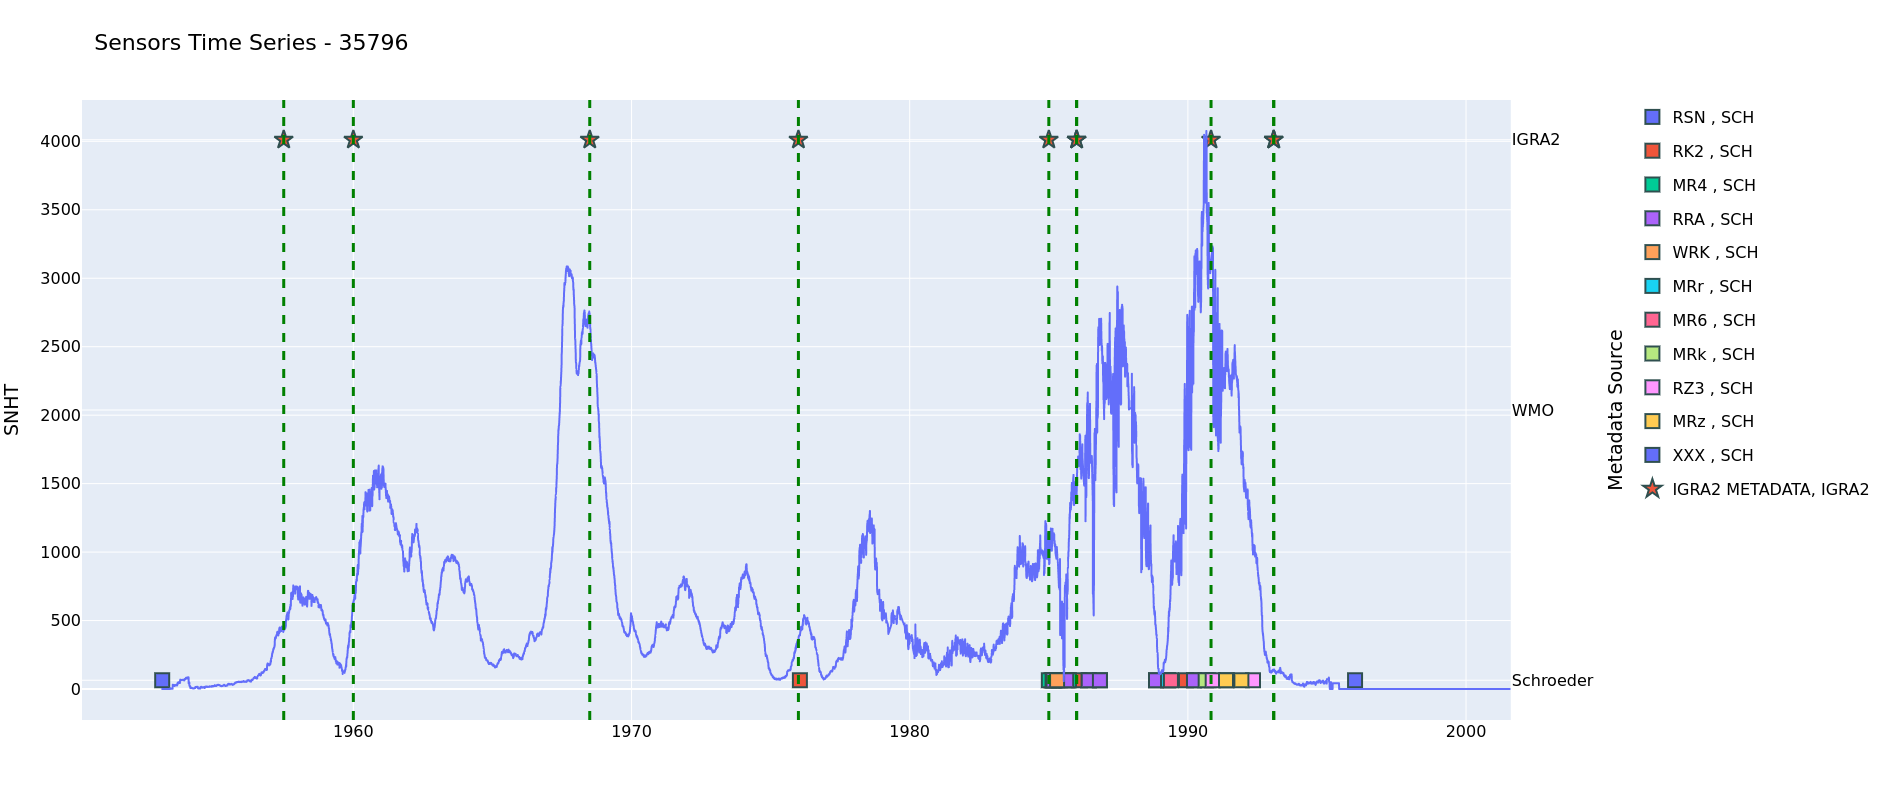

In [40]:
s.show()

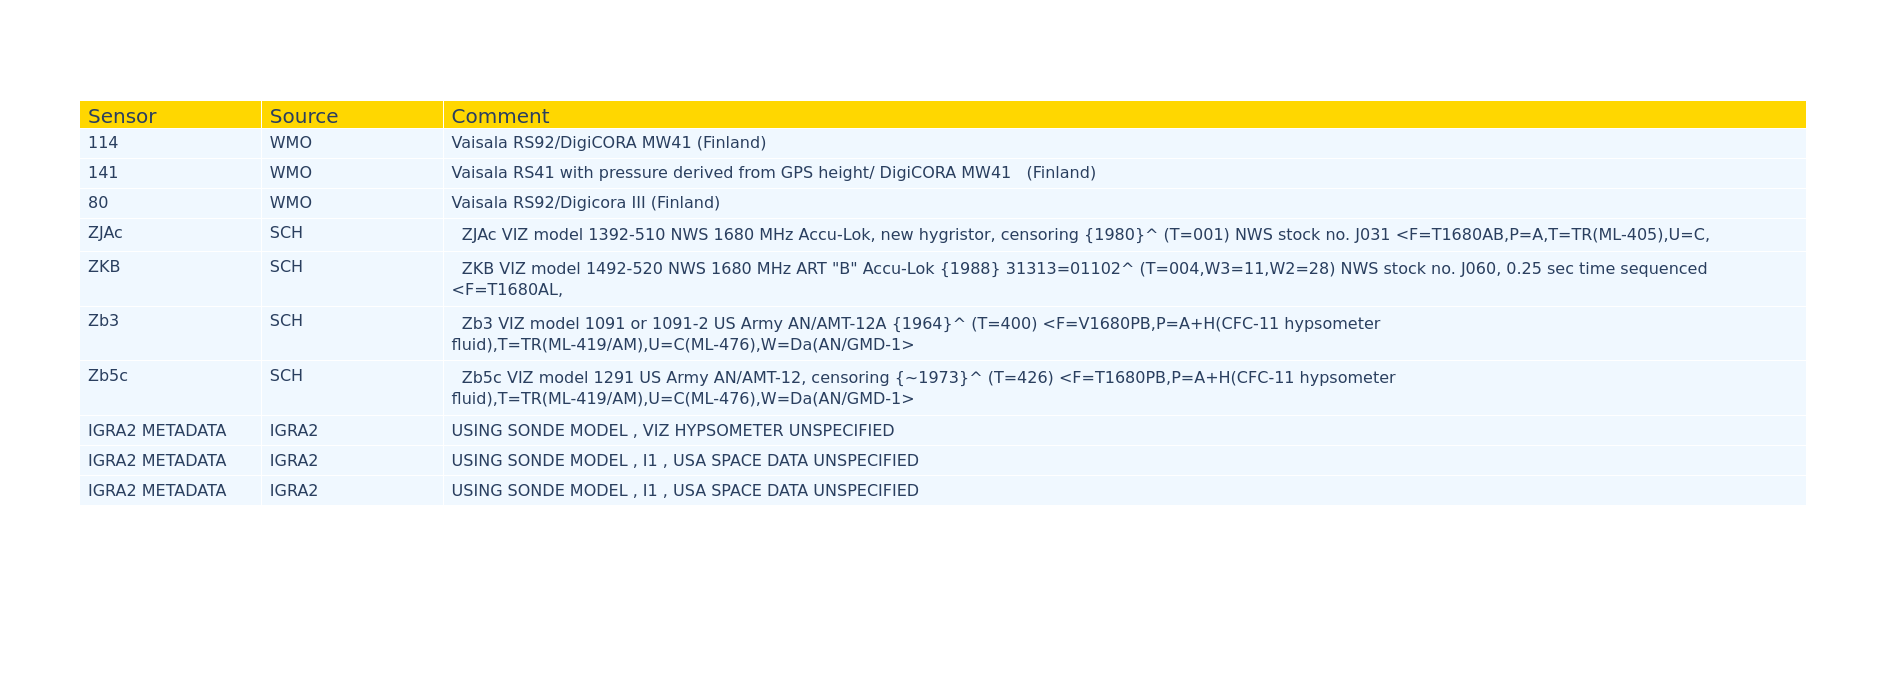

In [23]:
t.show()